In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
# from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn
from cuml.svm import SVC
import cupy

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')


X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

## PCA

## JL

In [11]:
def create_matrix_feature(d,n):
    matrix = np.random.normal(loc=0, scale=1.0/np.sqrt(n), size=(d, n))
    return matrix
output_dim=20
matrix_1=create_matrix_feature(X_train.shape[1],20)

In [12]:
X_train=X_train.dot(matrix_1)
X_test=X_test.dot(matrix_1)

### Naive Bayes ###

**Default**

In [13]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'priors': None, 'var_smoothing': 1e-09}
GaussianNB()
Naive_Bayes training
Accuracy: 0.37626984909754413
Macro f1: 0.299769143523152
Confusion Matrix:
 [[ 1583   154  2444    54  7156]
 [  381  1269  4264   750  2908]
 [ 1585  1082  8611   439 10838]
 [   43   742  1143   707   533]
 [ 2280   522  6764   186 14535]]
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.14      0.18     11391
           1       0.34      0.13      0.19      9572
           2       0.37      0.38      0.38     22555
           3       0.33      0.22      0.27      3168
           4       0.40      0.60      0.48     24287

    accuracy                           0.38     70973
   macro avg       0.34      0.29      0.30     70973
weighted avg       0.36      0.38      0.35     70973



### Logistic Regression ###

**Default**

In [14]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': True, 'warm_start': False}
LogisticRegression(verbose=True)
Logistic_Regression training
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          105     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56902D+05    |proj g|=  5.54995D+05


 This problem is unconstrained.



At iterate   50    f=  3.60587D+05    |proj g|=  2.94159D+04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



At iterate  100    f=  3.56152D+05    |proj g|=  1.15857D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  105    100    111      1     0     0   1.159D+04   3.562D+05
  F =   356152.30749486323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.42138559733983344
Macro f1: 0.3356519533082521
Confusion Matrix:
 [[  577    92  2357    35  8330]
 [   92  2128  4749   734  1869]
 [  455  1242 10222   303 10333]
 [   10  1372   724   910   152]
 [  656   375  7102    84 16070]]
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.05     

In [15]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Logistic Regression) --------------------
{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(random_state=42), 'n_jobs': -1, 'param_grid': {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': [

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.43095261578346694
Macro f1: 0.3477041304353328
Confusion Matrix:
 [[  326   110  2201     8  8746]
 [   34  2547  4454   582  1955]
 [  239  1467  9917   137 10795]
 [    3  1424   628   968   145]
 [  332   446  6637    44 16828]]
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.03      0.05     11391
           1       0.42      0.27      0.33      9572
           2       0.42      0.44      0.43     22555
           3       0.56      0.31      0.39      3168
           4       0.44      0.69      0.54     24287

    accuracy                           0.43     70973
   macro avg       0.44      0.35      0.35     70973
weighted avg       0.42      0.43      0.39     70973



### Random Forest ###

**Default**

In [16]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest")
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': True, 'warm_start': False}
RandomForestClassifier(n_jobs=-1, verbose=True)
Random_Forest training


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_fi

Accuracy: 0.4178067715891959
Macro f1: 0.33864612995146115
Confusion Matrix:
 [[  997   123  2943    14  7314]
 [   77  2389  4849   440  1817]
 [  510  1397 11140   130  9378]
 [    4  1459   860   663   182]
 [ 1102   528  8158    35 14464]]
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.09      0.14     11391
           1       0.41      0.25      0.31      9572
           2       0.40      0.49      0.44     22555
           3       0.52      0.21      0.30      3168
           4       0.44      0.60      0.50     24287

    accuracy                           0.42     70973
   macro avg       0.43      0.33      0.34     70973
weighted avg       0.41      0.42      0.39     70973



In [17]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest")
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Random Forest) --------------------
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
Grid

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.301 total time=  15.1s
[CV 3/3] END ..C=0.001, penalty=l2, solver=saga;, score=0.335 total time=  26.2s
[CV 2/3] END ...C=0.01, penalty=l2, solver=saga;, score=0.342 total time=  24.2s
[CV 2/3] END C=0.1, penalty=l2, solver=liblinear;, score=0.320 total time=  21.5s
[CV 3/3] END ....C=0.1, penalty=l2, solver=saga;, score=0.347 total time=  12.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time= 1.7min


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation.

Accuracy: 0.40928240316740166
Macro f1: 0.3368293852299904
Confusion Matrix:
 [[ 1224   171  3132    12  6852]
 [  130  2427  4634   457  1924]
 [  785  1575 11082   138  8975]
 [   11  1490   847   645   175]
 [ 1533   655  8391    38 13670]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.11      0.16     11391
           1       0.38      0.25      0.31      9572
           2       0.39      0.49      0.44     22555
           3       0.50      0.20      0.29      3168
           4       0.43      0.56      0.49     24287

    accuracy                           0.41     70973
   macro avg       0.41      0.32      0.34     70973
weighted avg       0.40      0.41      0.39     70973



### Decision Tree ###

**Default**

In [18]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree")
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
DecisionTreeClassifier()
Decision_Tree training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.3231510574443803
Macro f1: 0.2887038171200198
Confusion Matrix:
 [[2653  835 3204  148 4551]
 [ 910 2274 3211  970 2207]
 [3488 3054 7814  727 7472]
 [ 151 1114  753  732  418]
 [4681 2196 7575  373 9462]]
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.23      0.23     11391
           1       0.24      0.24      0.24      9572
           2       0.35      0.35      0.35     22555
           3       0.25      0.23      0.24      3168
           4       0.39      0.39      0.39     24287

    accuracy                           0.32     70973
   macro avg       0.29      0.29      0.29     70973
weighted avg       0.32      0.32      0.32     70973



In [19]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree")
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET --------------------
{'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_sampl

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.4007580347456075
Macro f1: 0.2925010549867094
Confusion Matrix:
 [[   21   141  2898    25  8306]
 [   20  1786  4509   629  2628]
 [   46  1306  9536   215 11452]
 [    3  1110   989   713   353]
 [   47   575  7204    74 16387]]
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.00      0.00     11391
           1       0.36      0.19      0.25      9572
           2       0.38      0.42      0.40     22555
           3       0.43      0.23      0.30      3168
           4       0.42      0.67      0.52     24287

    accuracy                           0.40     70973
   macro avg       0.35      0.30      0.29     70973
weighted avg       0.36      0.40      0.35     70973



### SVM ###

**Default**

In [20]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

{'handle': <pylibraft.common.handle.Handle object at 0x7f47d06f56b0>, 'verbose': 5, 'output_type': 'input', 'C': 1, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': None, 'class_weight': None, 'multiclass_strategy': 'ovo'}
SVC()
SVM training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


[D] [11:34:13.479674] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:34:15.996580] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.h:281 Solver is not converging monotonically. This might be caused by insufficient normalization of the feature columns. In that case MinMaxScaler((0,1)) could help. Alternatively, for nonlinear kernels, you can try to increase the gamma parameter. To limit execution time, you can also adjust the number of iterations using the max_iter parameter.
[D] [11:34:17.099640] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 158 outer iterations, total inner 34692 iterations, and diff 0.000946
[D] [11:34:17.257687] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:34:28.021181] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 384 outer iterations, total inner 79411 iterations, and diff 0.000982

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ada Boost ###


**Default**

In [21]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost")
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
AdaBoostClassifier()
ADA_Boost training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._

Accuracy: 0.40357600777760555
Macro f1: 0.2832486041677106
Confusion Matrix:
 [[    0   114  2494    19  8764]
 [    0  1641  4863   464  2604]
 [    0  1079  9581   118 11777]
 [    0  1130  1199   560   279]
 [    0   443  6955    28 16861]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11391
           1       0.37      0.17      0.23      9572
           2       0.38      0.42      0.40     22555
           3       0.47      0.18      0.26      3168
           4       0.42      0.69      0.52     24287

    accuracy                           0.40     70973
   macro avg       0.33      0.29      0.28     70973
weighted avg       0.34      0.40      0.35     70973



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost")
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (AdaBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': 42, 'estimator': AdaBoostClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100]},
             scoring='f1_macro', verbose=4)
ADA_Boost training
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.4120440167387598
Macro f1: 0.30419650138048854
Confusion Matrix:
 [[    5   101  2569    20  8696]
 [    4  1841  4868   554  2305]
 [    3  1157  9968   153 11274]
 [    0  1170  1031   756   211]
 [    1   412  7157    43 16674]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.00      0.00     11391
           1       0.39      0.19      0.26      9572
           2       0.39      0.44      0.41     22555
           3       0.50      0.24      0.32      3168
           4       0.43      0.69      0.53     24287

    accuracy                           0.41     70973
   macro avg       0.42      0.31      0.30     70973
weighted avg       0.41      0.41      0.36     70973



### XG Boost ###

**Default**

In [23]:
model_xg = model_classifier(cupy.array(X_train),cupy.array(X_test),Y_train,Y_test,XGBClassifier(device='cuda'),"XG_Boost")
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None,

In [24]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(cupy.array(X_train), cupy.array(X_test), Y_train, Y_test, xgb_grid, "XG_Boost")
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (XGBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__device': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__feature_types': None, 'estimator__gamma': None, 'estimator__grow_policy': None, 'estimator__importance_type': None, 'estimator__interaction_constraints': None, 'estimator__learning_rate': None, 'estimator__max_bin': None, 'estimator__max_cat_threshold': None, 'estimator__max_cat_to_onehot': None, 'estimator__max_delta_step': None, 'estimator__max_depth': None, 'estimator__max_leaves': None, 'estimator__min_child_weight': None, 'estimator__missing': nan, 'estimator__monotone_constraints': None, 'es

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:48:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:48:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

[CV 3/3] END learning_rate=0.01, n_estimators=50;, score=0.171 total time=  53.6s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.172 total time= 1.8min
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.213 total time= 1.7min
[CV 2/3] END .learning_rate=1, n_estimators=100;, score=0.302 total time= 1.5min
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8;, score=0.256 total time=  12.1s


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END learning_rate=0.01, n_estimators=50;, score=0.170 total time=  53.9s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.193 total time=  52.5s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.190 total time=  53.8s
[CV 1/3] END ..learning_rate=1, n_estimators=50;, score=0.288 total time=  53.3s
[CV 2/3] END ..learning_rate=1, n_estimators=50;, score=0.293 total time=  52.5s
[CV 3/3] END .learning_rate=1, n_estimators=100;, score=0.306 total time= 1.7min
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0;, score=0.250 total time=  12.0s
[CV 1/3] END learning_rate=0.01, n_estimators=50;, score=0.168 total time=  53.5s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.170 total time= 1.8min
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.215 total time= 1.8min
[CV 3/3] END ..learning_rate=1, n_estimators=50;, score=0.288 total time=  52.9s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:48:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:48:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Accuracy: 0.4259225339213504
Macro f1: 0.3284195725438444
Confusion Matrix:
 [[  137   111  2479    15  8649]
 [    7  2232  4660   591  2082]
 [   84  1356 10169   164 10782]
 [    1  1353   726   871   217]
 [  110   473  6839    45 16820]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.01      0.02     11391
           1       0.40      0.23      0.30      9572
           2       0.41      0.45      0.43     22555
           3       0.52      0.27      0.36      3168
           4       0.44      0.69      0.54     24287

    accuracy                           0.43     70973
   macro avg       0.43      0.33      0.33     70973
weighted avg       0.42      0.43      0.38     70973



In [25]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

,times,accuracies,macro_f1s,macro_f1s_train,accuracies_train
Naive_Bayes,0.115166,0.376270,0.299769,0.298138,0.375143
Logistic_Regression,115.568049,0.430953,0.347704,0.345526,0.428326
Random_Forest,1534.356214,0.409282,0.336829,0.999981,0.999975
Decision_Tree,116.007687,0.400758,0.292501,0.323228,0.417396
SVM,82.439969,0.424993,0.252701,0.252252,0.423852
ADA_Boost,476.258464,0.412044,0.304197,0.305299,0.410925
XG_Boost,280.525275,0.425923,0.328420,0.399236,0.474122


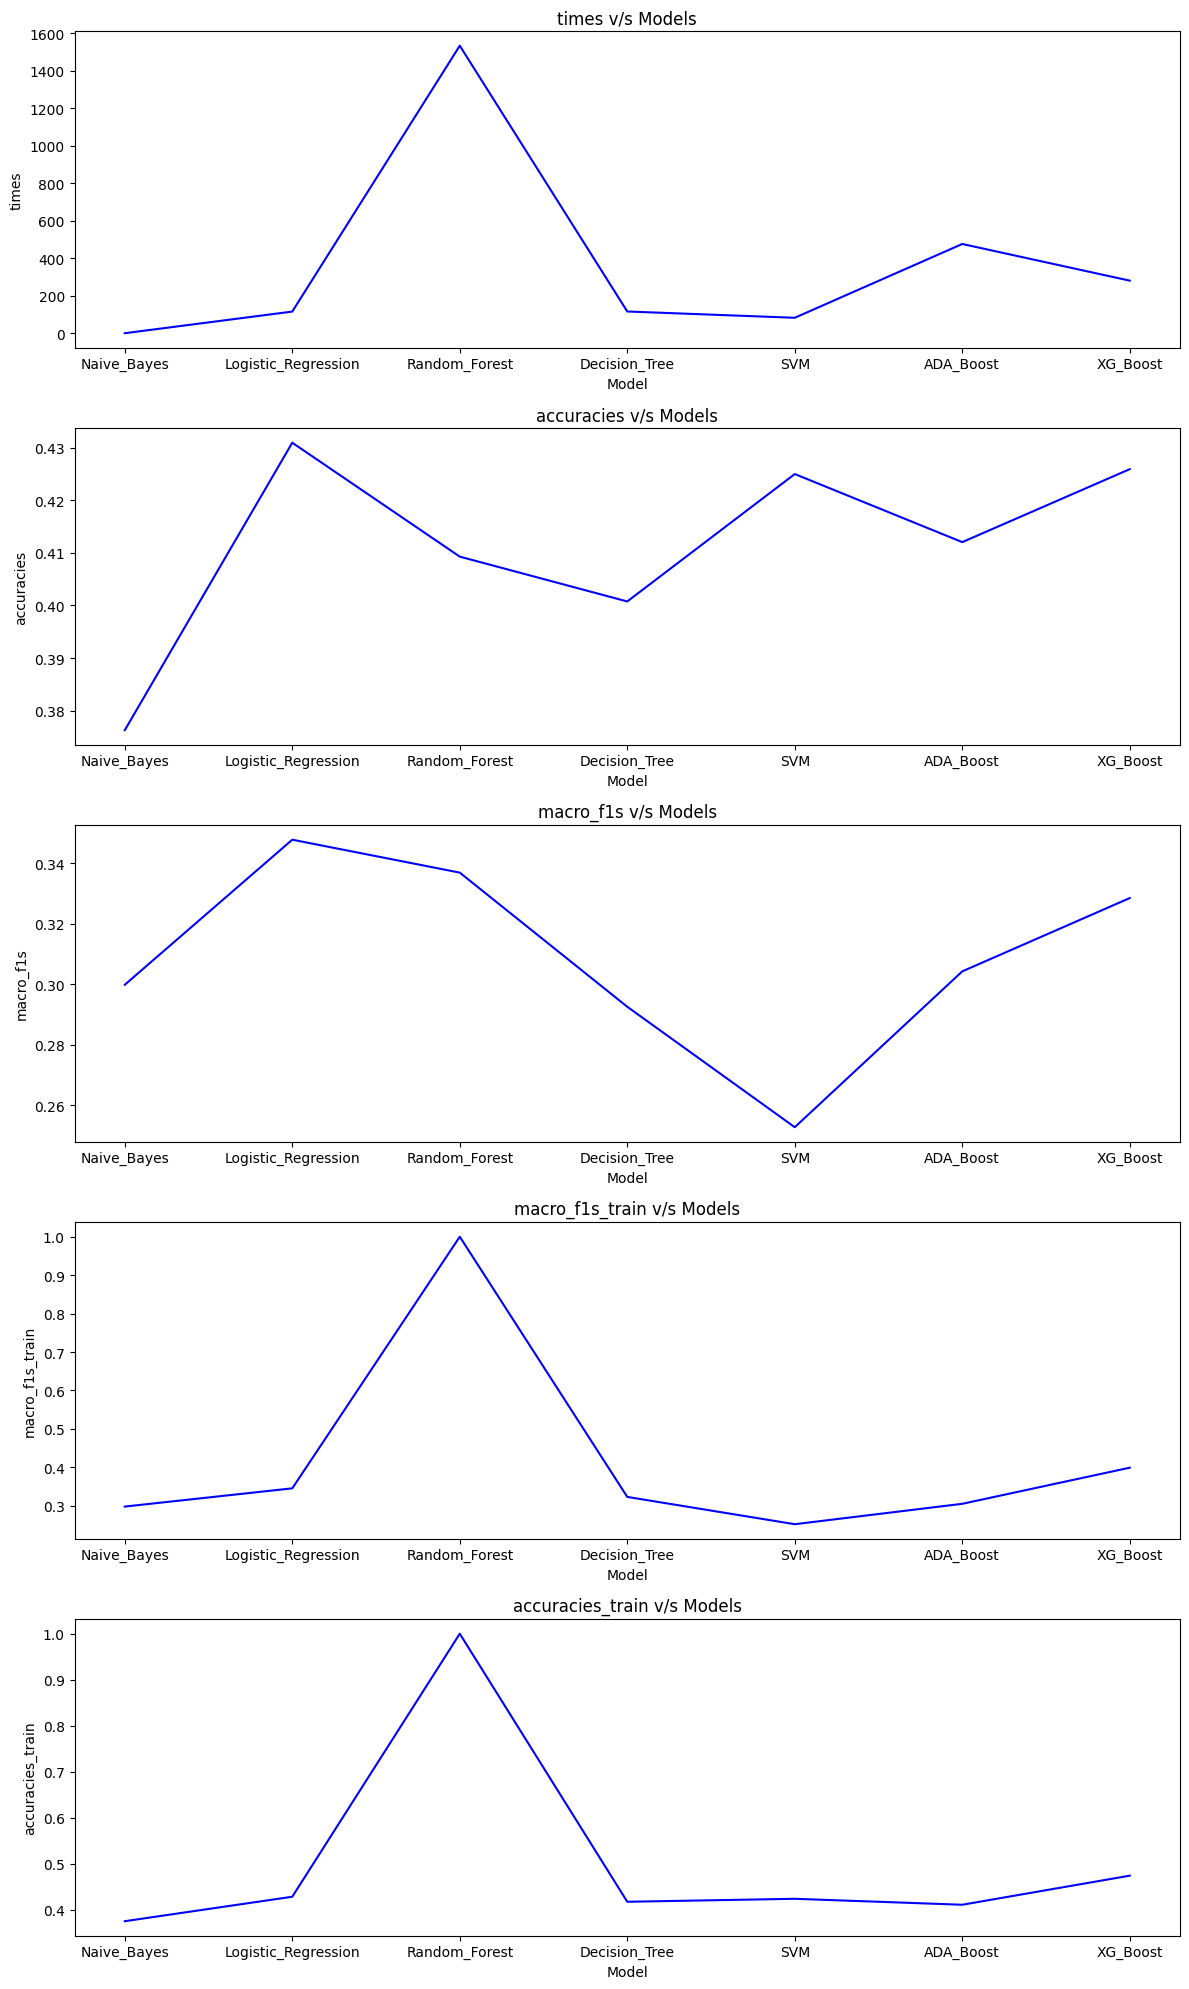

In [26]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()